## DSAN5650 Homework 3: Evaluating PGM Predictive Performance

In [1]:
import corrections
corrections.fetch("HW3")

**DSAN5650 HW3 Corrections**

None so far!


Last fetched: 2025-08-01 05:50:17 EDT

HW3 has a purpose above and beyond that which HW1 and HW2 had: namely, to **prepare you for your final projects!** While some parts were originally intended as writeups, to provide you with a "template" for how you could carry out the different options, I realized that between the two options of:

* (a) Giving you writeups and then a separate HW3 you have to worry about, and
* (b) Turning the writeups *into* HW3 problems,

(b) is probably 10x more helpful to you, and it's a win-win: you have have an actual grade-based incentive to work through these two "templates", and I can make sure that we're all on the same page in terms of expectations for the final project 😊

## The HW3 Study: What Employers Say vs. What They Do

The three parts of HW3 build towards developing a model of **discrimination on the basis of race and criminal record**, as an example of how you might start to pursue **Option 1: Modeling Social Phenomena with PGMs**, for your DSAN 5650 final project. For the sake of learning, it is hyper-simplified (focusing on just one specific study), in the sense that it leaves out a bunch of details (things like, a lit review) which should *not* be left out of a fully-formed project!

The study we'll be analyzing data from, titled ***"Walking the Talk?: What Employers Say Versus What They Do"*** [(Pager and Quillian 2003)](https://journals.sagepub.com/doi/abs/10.1177/000312240507000301), is a perfect candidate for analysis by way of PGMs, since it highlights the importance for social scientists of distinguishing between **latent** and **observed** variables.

The study was built upon a pair of investigations, which we'll use one-by-one to build up our model, then infer the parameters of our model from their two resulting datasets. The presentation here, for the sake of walking through a modeling procedure, is the reverse of their actual temporal ordering.

### Part 1: Data on *Attitudes* via Telephone Surveys

The survey was conducted via telephone, where the same employers as in the experimental audit (described below) were asked about their **attitudes** regarding whether or not they would hire someone with given characteristics, where the given characteristics varied across **race** (white vs. black) as well as **criminal record** (formerly-convicted vs. non-formerly-convicted). Unlike in the next section, however, the criminal-record question was asked **relative to** the no-criminal-record case, which is why we only have a single "yes" response rate for each race here. i.e., the questions they asked boiled down to

> Chad [the real name they used] is qualified for the position you advertised, but you find out that he was formerly convicted for a drug offense. Would you still hire him?

In Part 1.1a you'll load the data and plot an overview of the differential rates with which employers say they would "likely" or "very likely" hire Chad. And this plot will look as follows:

<center>
<img src="https://github.com/jpowerj/dsan-content/blob/24a7fe4df1a9e89c509ec2e102c4b1bfd5c4e1c5/2025-sum-dsan5650/hw3/survey_rates.png?raw=true" width="60%" />
</center>

But, before we can interpret this plot, we also need to understand the **paired experimental audit** that was performed on the same firms!

### Part 2: Data on *Behavior* via Experimental Audits

The experimental investigation is described more fully in a separate article by Pager *"The Mark of a Criminal Record"* [(Pager 2003)](https://www.journals.uchicago.edu/doi/10.1086/374403). It involved an **audit** of the same employers in the Milwaukee metro area, which worked as follows:

1.  A sample of 23-year-old college students from Milwaukee, split between white males and black males, were recruited with the stated goal of maximizing "comparability in terms of physical and interpersonal attributes."
2.  Once the sample had been recruited, participants were randomly split into groups-of-4 $g_i = (w_1, w_2, b_1, b_1)$.
3.  Although all members of the group-of-4 were given identical (fictionalized) resumes, in each job application "wave", one of the pair $(b_1, b_2)$ and then one of the pair $(w_1, w_2)$ were randomly assigned to also have a criminal record.
    
    In 74% of the randomly-chosen jobs, this came up immediately since the job applications required disclosure of past criminal conviction. For the other 26%, the applicants included 6 months of job experience within prison as part of their resume.
4.  The final results were tabulated based on how many of the individuals across all of the applications received callbacks.

You will load the data from this experimental audit and plot an overview of the results at the beginning of Part 2, and it will look as follows... painting a very different picture of employer behavior than the survey results!

<center>
<img src="https://github.com/jpowerj/dsan-content/blob/main/2025-sum-dsan5650/hw3/audit_rates.png?raw=true" width="60%" />
</center>

The final piece of background before you start analyzing and interpreting this data, however, is to understand **how** we're going to evaluate the extent to which our PGMs are "capturing" the attitudes and behaviors of the surveyed and audited firms!

## The HW3 Methodology: *Evaluating* Our Estimated Models on Test Data

Methodologically, this part will introduce you to a piece of the causal-analysis pipeline that you're probably/hopefully used to from other DSAN classes, but which we haven't touched on much yet in 5650. Namely, the **train-test split** approach to evaluating our models and distinguishing between "better" and "worse" models:

* **Splitting** our data into **training** and **test** subsets, and then
* **Evaluating** them on a relevant metric of predictive accuracy

Although **accuracy** often feels intuitively like the most appropriate evaluation metric, in most machine learning contexts it turns out to be not so helpful, since e.g. it rewards ML algorithms that just always guess the most-common class rather than actually learning the statistical relationship of interest. If we're trying to diagnose a rare disease that only occurs in 1% of the population, for example, the ML algorithm can achieve 99% accuracy by just always predicting no-disease (rather than learning to **distinguish** the disease cases from non-disease cases).

Thus, in general, for discrete classification tasks the [F1 score](https://en.wikipedia.org/wiki/F-score) is usually more appropriate. In this assignment, though, we will be **predicting probabilities** of being hired for individuals with different characteristics, which entails using the [AUC metric](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc) to evaluate the *tradeoff* between false positives and false negatives as we change the **threshold** for predicting a hiring from 0 to 1.

### Quick Overview of ROC Curve $\rightarrow$ AUC Metric

Since that last sentence is a bit vague, a more direct way of understanding this **threshold-based** evaluation is as follows. Once you've trained a model in PyMC, you can use its `.sample_predictive_posterior()` function to obtain a bunch of simulated datasets **generated by** the model (on the basis of its now-estimated parameter valuers). Since the default number of draws is 500, this corresponds to 500 generated hire/no-hire values for each individual in the dataset.

With these 500 hire/no-hire guesses for $i$ in hand, you can then compute their **mean** to obtain a point estimate of the model's **estimated probability that this individual $i$ is hired**. We'll call this mean $\hat{p}_i$, then use it to **evaluate** the model's predictions by constructing an **ROC Curve** via the following steps:

1.  First, we set up a plot in the $xy$-plane, where both $x$ and $y$ range from 0 to 1, and where the the $x$-axis is labeled **false positive rate** and the $y$-axis is labeled **true positive rate**.
2.  To get our first point on this **ROC Curve**, we set a threshold of **$\theta = 0.0$** for positive prediction. Meaning, we "convert" the predicted probabilities $\hat{p}_i$ generated by our model into actual predictions via the rule
    $$
    \text{Prediction}_i(0.0) = \begin{cases}
      1 &\text{if }\hat{p}_i \geq 0.0 \\
      0 &\text{otherwise}
    \end{cases}
    $$
    This will then generate some number of correct predictions (for all cases where person $i$ was actually hired), but also a bunch of false positives, since it's predicting 1 *no matter what*. So, we compute the False Positive Rate $FPR = \frac{\# FP}{\# FP + \# TN}$ under this prediction rule (where $\#$ means "number of", and $TN$ means "true negatives", so $\# TN$ means "number of true negatives"), along with the True Positive Rate $TPR = \frac{\# TP}{\# TP + \# FN}$, and add a point to the ROC curve created in the previous step at exactly the coordinates $(FPR, TPR)$.
3.  Then, we **increase the threshold** by some increment (say, $0.1$), and re-do Step 1. Meaning, we now generate a new set of predictions using the rule
    $$
    \text{Prediction}_i(0.1) = \begin{cases}
      1 &\text{if }\hat{p}_i \geq 0.1 \\
      0 &\text{otherwise}
    \end{cases}
    $$
    And, like in the previous step, this will generate a False Positive Rate $FPR$ and a True Positive Rate $TPR$, which we plot as a second point in our ROC Curve.
4.  We continue with this process, incrementing the threshold $\theta$, generating predictions via
    $$
    \text{Prediction}_i(\theta) = \begin{cases}
      1 &\text{if }\hat{p}_i \geq \theta \\
      0 &\text{otherwise}
    \end{cases}
    $$
    and then adding the resulting $(FPR, TPR)$ point to our ROC Curve until we reach $\theta = 1.0$ (at which point we're classifying every point as *negative*/no-hire, no matter what!)

The plot obtained using this method is called the **ROC Curve**, and if you think about the difference between a "fake" learning method that just randomly guesses between 0 and 1, and the "real" learning that you hope your chosen ML algorithm is performing, you'll arrive at the result that a good measure of "How well is my algorithm doing relative to random-guessing?" is precisely the **area underneath the curve**, or **AUC**, generated by connecting the points plotted in Steps 1 through 4 above. A random-guessing algorithm will obtain an **AUC** of 50%, whereas ML algorithms that more effectively **distinguish** the positive from the negative cases will have AUC scores which exceed 50%.

# [Part 1] Modeling *Attitudes* with Survey Data

In [2]:
#%run jupyter_fixes.ipynb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import patchworklib as pw
import pymc as pm
import arviz as az

<Figure size 100x100 with 0 Axes>

## [Part 1.1] Loading and Preparing the Dataset

Run the following code to load the survey data:

In [4]:
survey_df = pd.read_csv("./data/pager_matched_surveys.csv")
survey_df.head()

,survey_id,firm_id,con,race,race_str,sayhire
0,0,0,0,0,White,1
1,1,0,1,0,White,0
2,2,0,0,1,Black,1
3,3,0,1,1,Black,0
4,4,1,0,0,White,1


By printing the first 5 rows, we can see how:

* `survey_id` uniquely identifies **responses to vignettes**,
* `firm_id` uniquely identifies the **firm** responding to the survey (hence, there are four `survey_id` values for each `firm_id`)
* `con` and `race` represent the **features** we have available for predicting the survey response (`race_str` is there to help us keep track of which numeric value is mapped to which race value)
* `sayhire` is the **outcome** that we care about: whether or not the employer said they would be "likely to hire" Chad from the survey vignette.

Next, the following code aggregates the data into the four possible `(race,con)` pairs, and computes the rate of "likely" responses for each group:

In [5]:
rate_df = survey_df.groupby(['race_str','con'])['sayhire'].mean().to_frame().reset_index()
rate_df.rename(columns={'sayhire': 'sayhire_rate'}, inplace=True)
rate_df

,race_str,con,sayhire_rate
0,Black,0,1.000000
1,Black,1,0.604651
2,White,0,1.000000
3,White,1,0.627907


Now, run the following code to generate the plot from above, showing the relative "likely hire" rates for the four vignettes used in the survey:

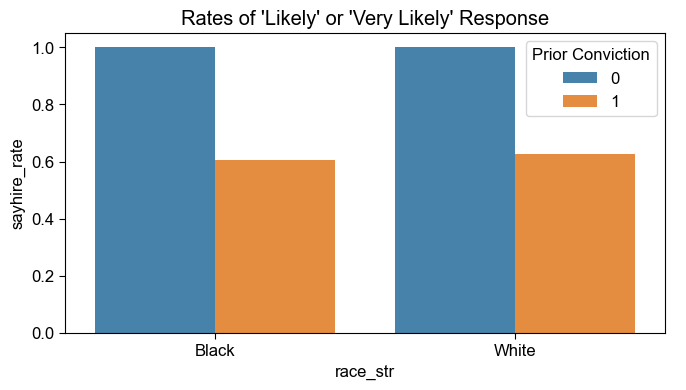

In [6]:
plot_df = rate_df.rename(columns={'con': 'Prior Conviction'})
ax = pw.Brick(figsize=(6, 3))
sns.barplot(
    x="race_str", y='sayhire_rate', hue='Prior Conviction', data=plot_df,
    alpha=0.9, ax=ax,
);
ax.set_title("Rates of 'Likely' or 'Very Likely' Response")
ax.savefig()

So, going off of *just* this survey-based investigation, we might think that the only salient variable we'd need to include would be one indicating **whether or not the applicant has a prior conviction**. In other words, this seems to indicate that we can "capture" employer behavior(🧐)---say, in order to make accurate **predictions** of job-applicant success---using only prior-conviction status. A tabulation of how often employers say they would likely hire an applicant, by race, seems to confirm this visual intuition, with the white Chad vignette eliciting only a slightly higher `sayhire` probability than the black Chad vignette:

In [7]:
survey_df.groupby('race_str')['sayhire'].mean()

race_str
Black    0.802326
White    0.813953
Name: sayhire, dtype: float64

In Part 1 we'll explore the relative performance of models with and without conviction status and race, then in Part 2 we'll move to a model of **observed** behavior (rather than hypothetical behavior), where we'll obtain very different results! So, in Part 3 we'll address this discrepancy head on, by modeling Attitude-Behavior Consistency directly.

### [Question 1.1.1] Train-Test Split

To achieve a probabilistic split of the data into **training** and **test sets**, we don't need to reinvent the wheel! `scikit-learn` has its own `train_test_split()` function we can import, that does exactly what we need in Parts 1 and 2 (in Part 3 we will have to be more careful about how we perform this split, but, `train_test_split()` is the "industry standard" for sample-splitting!).

So, your job in the following code cell is to use the imported `train_test_split()` function to split `survey_df` into:

* A **training set** named `train_df` containing 80% of the rows in `survey_df`, and
* A **test set** named `test_df` containing the remaining 20% of the rows in `survey_df`

*Make sure to pass the `random_state=5650` argument to the `train_test_split()` function, so that our solution output will match yours!*

In [12]:
# @title Q1.1.1-response

from sklearn.model_selection import train_test_split

# Your code here: separate survey_df into train_df and test_df
train_df, test_df = train_test_split(survey_df, test_size=0.2, random_state=42)
# Once you've created train_df and test_df, you can uncomment the following line
# to make sure that they have the expected dimensions
train_df.shape, test_df.shape

((137, 6), (35, 6))

In [10]:
# @title Q1.1.1-public-tests
q1_1_1_public_tests = {
    'train_df defined': '✅ Passed!' if 'train_df' in globals() else '🔲 No variable named train_df exists in Python memory',
    'test_df defined': '✅ Passed!' if 'test_df' in globals() else '🔲 No variable named test_df exists in Python memory',
}
q1_1_1_public_tests

{'train_df defined': '✅ Passed!', 'test_df defined': '✅ Passed!'}

### [Question 1.1.2] The Feature Matrices $\mathbf{X}$ and Label Vectors $\mathbf{y}$

Next, in the following cell, create a further split of `train_df` into:

* A Pandas `DataFrame` named `X_train`, containing only the numeric **features** mentioned above (`race` and `con`), and
* A Pandas `Series` object named `y_train`, containing only the single **outcome** mentioned above (`sayhire`)

Then do the same for `test_df` (creating `X_test` and `y_test`).

In [19]:
# @title Q1.1.2-solution

# Your code here: create DataFrame objects X_train and X_test, and Series
# objects y_train and y_test
X_train = train_df[['race','con']]
y_train = train_df['sayhire']

X_test = test_df[['race','con']]
y_test = test_df['sayhire']

# Once you've created the four objects, you can uncomment the following line to
# make sure that they have the expected dimensions
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((137, 2), (35, 2), (137,), (35,))

In [12]:
# @title Q1.1.2-public-tests
q1_2_2_varnames = ['X_train', 'X_test', 'y_train', 'y_test']
q1_2_2_public_tests = {
    f'{cur_varname} defined': '✅ Passed!' if cur_varname in globals() else f'🔲 No variable named {cur_varname} exists in Python memory'
    for cur_varname in q1_2_2_varnames
}
q1_2_2_public_tests

{'X_train defined': '✅ Passed!',
 'X_test defined': '✅ Passed!',
 'y_train defined': '✅ Passed!',
 'y_test defined': '✅ Passed!'}

Finally, the following cell just creates an `OrderedDict`, which we'll use to store the results for each model so that we can generate a final "which model performed best?" plot at the end of Part 1!

In [21]:
from collections import OrderedDict
survey_model_aucs = OrderedDict()

## [Part 1.2] Baseline Model: Always Guess Most-Frequent Label

To start off, one of the biggest biggest (I can't emphasize this enough... biggest!) issues in Machine Learning evaluations specifically is the lack of a **baseline model** that your audience can use to understand **what it means** that your model has some performance metric value $x$!

This is crucial in the sense that, it's literally how we know whether or not your machine **learning** algorithm is actually **learning** anything: consider a model that just always says "yes":

In [22]:
def my_fancy_model(features):
    return 1

X_train_copy = X_train.copy()
X_train_copy['predictions'] = X_train_copy[['con','race']].apply(my_fancy_model, axis=1)
X_train_copy.head()

,race,con,predictions
101,0,1,1
56,0,0,1
42,1,0,1
82,1,0,1
65,0,1,1


Or a model that flips a coin and says "Yes" or "No" accordingly:

In [23]:
def my_even_fancier_model(features):
    return np.random.randint(2)

X_train_copy = X_train.copy()
X_train_copy['predictions'] = X_train_copy[['con','race']].apply(my_even_fancier_model, axis=1)
X_train_copy.head()

,race,con,predictions
101,0,1,0
56,0,0,0
42,1,0,1
82,1,0,1
65,0,1,0


If one of these models outperforms your model, then, it's difficult to conceive of your model as "learning" anything, if we want that word to retain its meaning!

In the case of our model of hiring, however, we know that there are always going to be *idiosyncratic factors* that we can't include, like whether the interviewer has a headache in the interview, whether their favorite sports team won their game earlier that day, etc. So, rather than predicting 0/1 hire/no-hire outcomes, we'll aim to predict the **probability** that a person $i$ with characteristics $X_i = (C_i, R_i)$ ($C_i$ representing their prior conviction status and $R_i$ representing their reported race) is hired.

In this setting, the parallel to "just always guess the most common outcome" is "just always guess the overall probability of hiring regardless of individual characteristics". So, we'll write the simplest possible model in PyMC, which just learns a single parameter $p$, representing the overall probability of an individual $i$ being hired if we **don't observe anything at all about that individual**.

In other words, if this baseline model is successful, it should approximately recover the overall probability of hiring that we see in the data, the probability that the label `y` is `1`:

In [24]:
y_train.value_counts(normalize=True)

sayhire
1    0.80292
0    0.19708
Name: proportion, dtype: float64

I say "approximately" because, keep in mind that we're in Bayesian-modeling world, where we put **priors** on all of the parameters we'd like to learn! So, it will be the result of starting with some **prior distribution** over possible `p_hire` values, then updating this prior distribution to take into account each observed datapoint.

Specifically, we'll use a continuous Uniform distribution $p \sim \mathcal{U}[0,1]$ as our prior, though from here on out we'll write it in terms of the **Beta distribution** as $p \sim \textsf{Beta}(1,1)$ because the two-parameter Beta distribution makes it more clear how this prior is mathematically equivalent to the uncertainty we'd have after observing a **single** "positive" ($\textsf{Hired}$) outcome and a single "negative" ($\textsf{Not Hired}$) outcome: that is, it models the hire vs. no-hire decision (before we get to observe any actual data) as a fair coin flip.

***(If this point about the Beta distribution doesn't make sense to you yet, check out the [Writeup](https://jjacobs.me/dsan5650/writeups/priors/) on the course website which walks through Skeptical, Weakly-Informative, and Strongly-Informative Priors!)***

### [Question 1.2.1] Write and Visualize the Baseline Model

Baseline model time! I was originally going to torture you by making you go through these steps with **two** models---one using a $\text{Beta}(1,1)$ prior and the other using the (improper) **flat** prior that was discussed briefly in class (the "frequentist prior")---but decided against it. Instead, in your free time, you can change your prior on `p_hire` from `pm.Beta()` to `pm.Flat()` to see how it affects the results!

> *If you do follow this optional path, a **hint** is that the flat prior should perform better on the **training** data, but the Beta prior should perform better on the **test** data...*
> 
> *And, whether you follow the optional path or not, you should **think about why this is the case!** Because, it's an important lesson in how **the choice of appropriate regularizing priors** is exactly the Bayesian approach to avoiding **overfitting!***

Once you've written the model and used the included `pm.model_to_graphviz()` call to visualize it, the result should look as follows:

<center>
<img src="https://raw.githubusercontent.com/jpowerj/dsan-content/e628c12c32570ad88a0345ca223d3fa03100eeca/2025-sum-dsan5650/hw3/baseline_sayhire.svg" width="15%" />
</center>

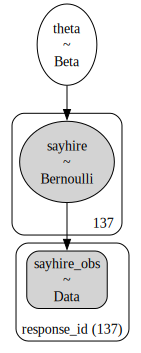

In [30]:
# @title Q1.2.1-response
train_coords = {
    'response_id': X_train.index.values
}

# Your code here: create a pm.Model object named nofeats_model as described above
with pm.Model(coords=train_coords) as nofeats_model:
    p_sayhire = pm.Beta("theta", 1, 1)
    sayhire_obs = pm.Data("sayhire_obs", y_train, dims="response_id")
    sayhire = pm.Bernoulli("sayhire", p = p_sayhire, observed=sayhire_obs)
# Once you've written the model, uncomment this line to visualize it as a PGM
pm.model_to_graphviz(nofeats_model)

In [47]:
# @title Q1.2.1-public-tests
q1_2_1_public_tests = {
    'nofeats_model defined': '✅ Passed!' if 'nofeats_model' in globals() else '🔲 No variable named nofeats_model exists in Python memory',
}
q1_2_1_public_tests

{'nofeats_model defined': '✅ Passed!'}

### [Question 1.2.2] Parameter RVs vs. Data RVs

This is a somewhat confusing point about Bayesian models that you don't encounter in frequentist settings, so it's good to think about it early and often!

Since the Bayesian models we're writing in PyMC are **generative**, and since they're just Python "encodings" of **PGMs** (hence the ability to use `pm.model_to_graphviz()`), **every variable in the entire model is (technically) a Random Variable!** Meaning, in the case of our baseline model, all of:

* `p_sayhire`,
* `sayhire`, and
* `sayhire_obs`

are actually represented in PyMC's memory as Random Variables. Though this can be confusing at first, it "unlocks" some amazing features of Bayesian inference, the main one being (in my mind) that **we get missing-data imputation for free!** Meaning: since every data point is represented as a RV with its own distribution (which you'll see below), the only difference between fitting our model to a dataset $\mathbf{D}_{1}$ with 30 non-missing observations and another dataset $\mathbf{D}_2$ with 29 non-missing observations but one missing observation at index $i$ is that **the RV for `data[i]` becomes a *latent* rather than *observed* Random Variable**, and we proceed with inference the exact same in either case 😎

The only "cost" we incur for this free bonus feature is that we have to be a bit more careful in keeping track of which variables are indeed **parameters** of the model that we're trying to estimate, and which are just (possibly-observed but possibly-missing) "slots" for data observations.

To this end, your Question 1.3b is, **which of the following are *parameters of the model* that we want to estimate?** (And that we will estimate in the next step, using `pm.sample()`.) ***(Check all that apply, by setting the code cell variable accordingly)***

* (a) `p_sayhire`
* (b) `sayhire`

In [ ]:
# @title Q1.2.2-response
q1_2_2_response = {
    'a': True, # Change to True to "check" option (a)
    'b': False, # Change to True to "check" option (b)
}

In [49]:
# @title Q1.2.2-public-tests
q1_2_2_public_tests = {
    'q1_2_2_response defined': '✅ Passed' if 'q1_2_2_response' in globals() else '🔲 No variable named q1_2_2_response exists in Python memory',
}
q1_2_2_public_tests

{'q1_2_2_response defined': '✅ Passed'}

### [Question 1.2.3] Estimate Model Parameters

Next, use the `pm.sample()` function (making sure to remember `random_seed=5650`!) to draw estimates of the posterior distribution, storing the result in a variable named `nofeats_idata`.

If the model has been specified correctly, the included `az.summary()` call should display information (mean, sd, etc.) about the estimated posterior distribution over values of the model's sole parameter (which is a hint for the previous question 😜)

In [32]:
# @title Q1.2.3-response

# Your code here: Estimate the posterior distribution of nofeats_model
with nofeats_model:
    nofeats_idata = pm.sample(random_seed=5650)
# Once you've stored the posterior inference data in nofeats_idata, uncomment
# the following line to display a summary of the inferred p_hire distribution
az.summary(nofeats_idata)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.797,0.034,0.733,0.858,0.001,0.0,1785.0,2783.0,1.0


In [51]:
# @title Q1.2.3-public-tests
q1_2_3_public_tests = {
    'nofeats_idata defined': '✅ Passed!' if 'nofeats_idata' in globals() else "🔲 No variable named 'nofeats_idata' exists in Python memory",
}
q1_2_3_public_tests

{'nofeats_idata defined': '✅ Passed!'}

### [Question 1.2.4] Extract Posterior Predictive Distribution for Training Data

Now for the whole reason we split the data into training and test sets! Though we **really** care about the predictive performance on unseen test data, here before we get to that let's use the `pm.sample_posterior_predictive()` function to generate the estimated distributions over **outcomes**. So, in this case, this will actually be 137 different distributions over possible values of `sayhire`, one for each row in the training data.

In the following code cell, use `pm.sample_posterior_predictive()` to draw these estimates, making sure to include `random_seed=5650`. The included `az.summary()` call will then display a table summarizing the distributions over possible `sayhire` values for each observation in the training data.

In [35]:
# @title Q1.2.4-response

# Your code here: extract posterior predictive distribution for nofeats_idata
with nofeats_model:
    nofeats_postpred_idata = pm.sample_posterior_predictive(nofeats_idata, random_seed=5650)
# Once you've drawn estimates from the posterior predictive distribution, and stored the
# results in a variable named nofeats_postpred_idata, uncomment the following line to
# generate a table of results!

az.summary(nofeats_postpred_idata)

Sampling: [sayhire]


Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sayhire[0],0.792,0.406,0.0,1.0,0.007,0.005,3790.0,3790.0,1.0
sayhire[1],0.794,0.405,0.0,1.0,0.007,0.005,3732.0,3732.0,1.0
sayhire[2],0.803,0.398,0.0,1.0,0.006,0.005,3862.0,3862.0,1.0
sayhire[3],0.806,0.396,0.0,1.0,0.007,0.005,3699.0,3699.0,1.0
sayhire[4],0.803,0.398,0.0,1.0,0.006,0.005,3755.0,3755.0,1.0
...,...,...,...,...,...,...,...,...,...
sayhire[132],0.807,0.395,0.0,1.0,0.006,0.005,3893.0,3893.0,1.0
sayhire[133],0.797,0.402,0.0,1.0,0.007,0.005,3767.0,3767.0,1.0
sayhire[134],0.801,0.399,0.0,1.0,0.006,0.005,3962.0,3962.0,1.0
sayhire[135],0.799,0.401,0.0,1.0,0.006,0.005,3817.0,3817.0,1.0


In [53]:
# @title Q1.2.4-public-tests
q1_2_4_public_tests = {
    'nofeats_postpred_idata defined': '✅ Passed!' if 'nofeats_postpred_idata' in globals() else "🔲 No variable named 'nofeats_postpred_idata' exists in Python memory",
}
q1_2_4_public_tests

{'nofeats_postpred_idata defined': '✅ Passed!'}

### [Question 1.2.5] Evaluate Predictive Performance on Training Data

One of the more confusing aspects of Bayesian modeling at first, admittedly, is that from frequentist-stats world we're used to obtaining **point estimates** of things, and then maybe **standard errors** describing our uncertainty about these point estimates... In Bayes world, model results are **not** point estimates of things, but entire **distributions** over possible values of the things! Therefore, as mentioned above, rather than 137 estimates of `sayhire` values (which would be either `0` or `1`), we have **4000 draws** from the posterior distribution of each survey's `sayhire` value: 4 Markov chains, each of which produces 1000 estimates.

There is a ton of cool stuff that this having-a-distribution-rather-than-a-point-estimate unlocks for us, so it's actually a shame to collapse it all back down into point estimates 😭. But, to be able to evaluate its predictive performance as a probabilistic classifier of `sayhire` values, we'll do this collapsing: in the following cell, compute the **mean** over all 4000 draws of `sayhire` for each `response_id` in the dataset, so that you end up with just a **vector** of 137 means with the name `nofeats_train_means`. (Note that, you can transform the vector into a Pandas `Series` object, as I've done in class, or you can just keep it in PyMC's default `xarray` format; either one will work with the provided `plot_roc()` function).

Once your `nofeats_train_means` vector of "predicted scores" is ready, the provided code at the end of the cell includes a `plot_roc()` function that we'll use from here on out to compare these predictions with the **observed** `sayhire` values in the training data. The function displays the ROC curve visually, then returns the numeric AUC metric value. Since this is just the **training** performance, we don't save it anywhere, but the fact that `plot_roc()` returns the AUC value will be important when we compute the **test** performance in the next step!

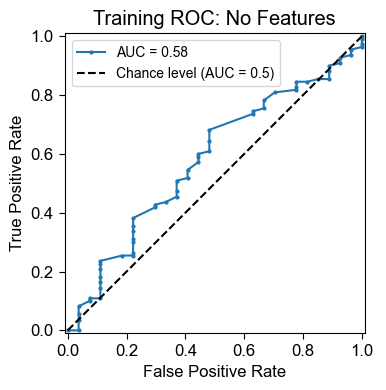

0.5797979797979798

In [76]:
# @title Q1.2.5-response

# Your code here: derive mean values for each of the posterior predictive distributions
# (one per observation in the training data)
nofeats_train_means = nofeats_postpred_idata.posterior_predictive['sayhire'].mean(dim=['chain','draw'])
# Provided plot_roc() function: Please use this function to visualize the ROC curve for the scores in
# nofeats_train_means, so that the autograder can evaluate your responses appropriately!
from sklearn.metrics import RocCurveDisplay, auc, roc_curve
def plot_roc(true_labels, pred_p_hire, plot_title="ROC Curve"):
    ax = pw.Brick(figsize=(3, 3))
    model_fpr, model_tpr, model_thresholds = roc_curve(
        y_true=true_labels, y_score=pred_p_hire, pos_label=1, drop_intermediate=True
    )
    model_auc = auc(model_fpr, model_tpr)
    roc_display = RocCurveDisplay(fpr=model_fpr, tpr=model_tpr, roc_auc=model_auc)
    roc_display = roc_display.plot(ax=ax, marker="o", markersize=2, plot_chance_level=True)
    ax.set_title(plot_title);
    ax.legend(fontsize=10);
    display(ax.savefig())
    return model_auc
plot_roc(y_train, nofeats_train_means, "Training ROC: No Features")

In [55]:
# @title Q1.2.5-public-tests
q1_2_5_public_tests = {
    'nofeats_train_means defined': '✅ Passed!' if 'nofeats_train_means' in globals() else "🔲 No variable named 'nofeats_train_means' exists in Python memory",
}
q1_2_5_public_tests

{'nofeats_train_means defined': '✅ Passed!'}

You should see a Training ROC curve that is... as bad as random-chance, and in fact a bit be worse (due to the noise we've introduced by estimating `p_sayhire` *then* drawing a bunch of Bernoulli-distributed `sayhire` values from it). But that's ok! This is the **baseline** model, where we haven't learned anything besides the overall probability of `sayhire`. Let's see how it performs on the **test** data before moving on to introduce actual **features** of the survey vignettes (the Chads...)

### [Question 1.2.6] Evaluate Predictive Performance on Test Data

One thing to note, before we dive into evaluating our model's performance on the **test** data, is that because of the stochastic split of the data into training and test sets, we expect the test set to have slightly different statistical properties from the training set! The theoretical point of the train-test split is to simulate **two** random draws from a larger population, with the training "draw" being 4 times larger than the test "draw".

So, run the following two code cells to see this in action:

In [56]:
y_train.value_counts(normalize=True)

sayhire
1    0.817518
0    0.182482
Name: proportion, dtype: float64

In [57]:
y_test.value_counts(normalize=True)

sayhire
1    0.771429
0    0.228571
Name: proportion, dtype: float64

You should see that the proportion of test observations with a `sayhire` value of `1` is slightly **lower** than the proportion of training observations with a `sayhire` value of `1`. So, to the degree that our model has fallen prey to **overfitting**, e.g. to the degree that it has just tried to **"memorize"** the training data rather than trying to **generalize** from it to the population it was drawn from, our **test** performance will be worse. (Which again, is the point of the priors in Bayesian data analysis!) This doesn't matter so much for our baseline model, since its just to check whether our "real" models are improving upon this baseline, but it's good to keep this in mind now as we move forward!

In the following code cell, you'll need to do something you didn't have to do for the training data evaluation. You'll need to:

1.  **Update the data** in `nofeats_model` so that it now has the **test** features as its observations (which will also require providing a new `coords` value, as the second argument to `pm.set_data()`, corresponding to the `response_id` values in the **test** data. Then, once the model's observed data has been updated,
2.  **Re-estimate** the posterior predictive distribution using `pm.sample_posterior_predictive()`, remembering to include `random_seed=5650`, and store the **35 newly-generated `sayhire` distributions** (one per label in `y_test`) in a variable named `nofeats_test_idata`.

Note that you should **not re-run `pm.sample()`** to generate these test predictions! In fact, if you do, it will just re-estimate the entire model (with the test data now just becoming the new training data), so that you will no longer be evaluating the model's **generalizability** to unseen data!

Since this `set_data()` $\rightarrow$ `pm.sample_posterior_predictive()` approach can be a bit daunting, we've made your lives a bit easier by just providing the code for extracting `sayhire` means and plotting the ROC curve. So, just focus on generating the posterior predictive distribution over the **test** data!

Sampling: [sayhire]


Output()

[0.788   0.79475 0.807   0.7945  0.7975  0.7935  0.7915  0.793   0.8015
 0.7985  0.8115  0.7985  0.79575 0.80525 0.8025  0.7985  0.80675 0.80325
 0.80125 0.79225 0.80525 0.809   0.79025 0.798   0.79875 0.795   0.79975
 0.798   0.79875 0.797   0.7975  0.7925  0.796   0.78475 0.8065 ]


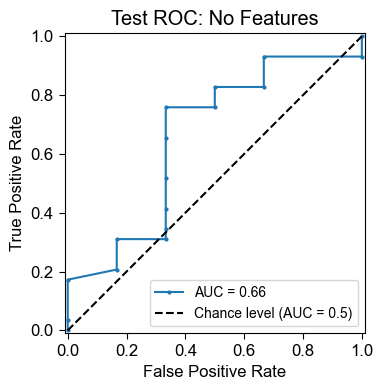

OrderedDict([('nofeats', 0.6580459770114943)])

In [83]:
# @title Q1.2.6-response

# Your code here: update the data in nofeats_model to be the *test* features,
# and then re-estimate the posterior predictive distribution conditional on
# this test data
test_coords = {
    'response_id': X_test.index.values
}
with nofeats_model:
    pm.set_data({"sayhire_obs": y_test}, coords=test_coords)
with nofeats_model:
    nofeats_test_idata = pm.sample_posterior_predictive(nofeats_idata, random_seed=5650)

# Provided code step 1: Extract means of sayhire values from the posterior predictive
# distribution given test data
nofeats_test_meanhired = nofeats_test_idata.posterior_predictive['sayhire'].mean(dim=['chain','draw'])
print(nofeats_test_meanhired.values)
# Provided code step 2: Plot Test ROC curve
nofeats_auc = plot_roc(y_test, nofeats_test_meanhired.values, "Test ROC: No Features")
# Provided code step 3: Store the resulting AUC value in surv_model_aucs, and display the set of
# AUCs we've computed thus far
survey_model_aucs['nofeats'] = nofeats_auc
survey_model_aucs

In [61]:
# @title Q1.2.6-public-tests
q1_2_6_public_tests = {
    'nofeats_test_idata defined': '✅ Passed!' if 'nofeats_test_idata' in globals() else "🔲 No variable named 'nofeats_test_idata' exists in Python memory",
}
q1_2_6_public_tests

{'nofeats_test_idata defined': '✅ Passed!'}

You should see even-worse performance than in the training-data case, which is still ok because it's a baseline model! (And, if I wanted to be annoying, I'd ask you to go back up now and replace the `pm.Beta()` prior with a `pm.Flat()` prior, to see how the test performance becomes even worse!)

## [Part 1.3] Model with Conviction Status Only

Thank you for trooping through the baseline model. Now for the more stimulating part, where you actually get to use machine learning to learn things!

### [Question 1.3.1] Write and Visualize the Conviction-Only Model

The logic for the conviction-status-only model will be similar to models from class and HW2, where instead of a single `p_sayhire` parameter you'll now have:

* A parameter `p_sayhire_nocon` representing the probability that the employer says they are "likely" to hire Chad in the vignette where Chad does not have a prior drug conviction, and
* A separate parameter `p_sayhire_con` for the case where vignette-Chad *does* have a prior drug conviction.

Then, the outcome `sayhire` will be modeled as a Bernoulli random variable, whose `p` parameter is drawn from the appropriate `p_sayhire` parameter among these two options (you should use PyMC's `pm.math.switch()` function to achieve this!)

As with the previous model, the `pm.model_to_graphviz()` call provided at the end of the code cell should be used to check that your model matches the above description. Once the model is set up correctly it should look like the following:

<center>
<img src="https://raw.githubusercontent.com/jpowerj/dsan-content/b108a8d0f8616935c7f88ebd262ad412ee55e4ba/2025-sum-dsan5650/hw3/sayhire_cononly.svg" width="50%" />
</center>

In [ ]:
# @title Q1.3.1-response
train_coords = {
    'response_id': X_train.index.values
}

# Your code here: implement the model as a pm.Model object with the name conviction_model

# Once you've written the model, uncomment the following line to generate a
# PGM representation of the model

# pm.model_to_graphviz(conviction_model)

In [63]:
# @title Q1.3.1-public-tests
q1_3_1_public_tests = {
    'conviction_model defined': '✅ Passed!' if 'conviction_model' in globals() else "🔲 No variable named 'conviction_model' exists in Python memory",
}
q1_3_1_public_tests

{'conviction_model defined': '✅ Passed!'}

### [Question 1.3.2] Parameter RVs vs. Data RVs

For the same reasons outlined in Question 1.2.2 earlier, specify **which of the following Python variables represent latent *parameters* that we'd like to estimate via this model**:

* (a) `con_obs`
* (b) `p_sayhire_con`
* (c) `p_sayhire_nocon`
* (d) `sayhire`
* (e) `sayhire_obs`

In [64]:
# @title Q1.3.2-response
q1_3_2_response = {
    'a': False, # Change to True to "check" option (a)
    'b': False, # Change to True to "check" option (b)
    'c': False, # Change to True to "check" option (c)
    'd': False, # Change to True to "check" option (d)
    'e': False, # Change to True to "check" option (e)
}

In [65]:
# @title Q1.3.2-public-tests
q1_3_2_public_tests = {
    'q1_3_2_response defined': '✅ Passed!' if 'q1_3_2_response' in globals() else "🔲 No variable named 'q1_3_2_response' exists in Python memory",
}
q1_3_2_public_tests

{'q1_3_2_response defined': '✅ Passed!'}

### [Question 1.3.3] Estimate Model Parameters

Now, use the `pm.sample()` function (making sure to remember `random_seed=5650`!) to draw estimates of the posterior distribution, storing the result in a variable named `conviction_idata`.

If the model has been specified correctly, the included `az.summary()` call at the end of the code cell should display information (mean, sd, etc.) about the estimated posterior distribution over values of the model's parameters.

In [ ]:
# @title Q1.3.3-response

# Your code here: Derive posterior estimates for model parameters

# Once you've estimated the posterior_distribution, and stored the result in
# conviction_idata, uncomment the following line to display a summary of the
# results
az.summary(conviction_idata)

In [67]:
# @title Q1.3.3-public-tests
q1_3_3_public_tests = {
    'conviction_idata defined': '✅ Passed!' if 'conviction_idata' in globals() else "🔲 No variable named 'conviction_idata' exists in Python memory",
}
q1_3_3_public_tests

{'conviction_idata defined': '✅ Passed!'}

### [Question 1.3.4] Evaluate Predictive Performance on Training Data

In the next question we'll skip evaluating predictive performance on training data, but for this part I want you to see what the ROC curve looks like for a model which does **significantly better than random guessing!**

So, in the following code cell, use `pm.sample_posterior_predictive()` (with `random_seed=5650`) to generate distributions over possible values of `sayhire` for each observation in the training data, storing the result in a variable named `conviction_train_idata`. The provided code at the end of the code cell will do the rest, computing means for each `response_id` value and evaluating these means in terms of AUC.

In [ ]:
# @title Q1.3.4-response

# Your code here: Extract posterior predictive distributions

# Provided code step 1: Extract means of sayhire values from the posterior predictive
# distribution given training data
conviction_train_meanhired = conviction_train_idata.posterior_predictive['sayhire'].mean(dim=['chain','draw'])
print(conviction_train_meanhired.values)
# Provided code step 2: Plot Training ROC curve
plot_roc(y_train, conviction_train_meanhired.values, "Training ROC: Conviction Status Model")

In [69]:
# @title Q1.3.4-public-tests
q1_3_4_public_tests = {
    'conviction_train_idata defined': '✅ Passed!' if 'conviction_train_idata' in globals() else "🔲 No variable named 'conviction_train_idata' exists in Python memory",
}
q1_3_4_public_tests

{'conviction_train_idata defined': '✅ Passed!'}

You should see an AUC score exceeding `0.75`! An increase of more than 25 percentage points over our baseline AUC score 🥳

### [Question 1.3.5] Evaluate Predictive Performance on Test Data

Here, as you did for the baseline model above, first use `pm.set_data()` to update the data stored in the PyMC model object to the **test** data, then use `pm.sample_posterior_predictive()` to draw from the predictive posterior distribution relative to the **test** data, storing the result in a variable named `conviction_test_idata`. The provided code will do the rest!

In [ ]:
# @title Q1.3.5-response
conviction_test_coords = {
    'response_id': X_test.index.values
}

# Your code here: update the data in conviction_model to the *test* data, then
# derive new posterior predictive distributions for the test observations

# Provided code step 1: Extract means of sayhire values from the posterior predictive
# distribution given test data
conviction_test_means = conviction_test_idata.posterior_predictive['sayhire'].mean(dim=['chain','draw'])
# Provided code step 2: Plot test ROC curve
conviction_auc = plot_roc(y_test, conviction_test_means, "Test ROC: Conviction Only")
# Provided code step 3: Store the AUC score in the model_aucs dictionary
survey_model_aucs['conviction_only'] = conviction_auc
survey_model_aucs

Like in the training data case, you should see a significant improvement in AUC score over the baseline value.

## [Part 1.4] Model with Race Only

Now, to verify our intuition about race being "less informative" in terms of predictive power with respect to employer *attitudes*, let's construct and estimate a similar model but only using the `race` feature.

**(Rather than thinking of this as tedious, think of it as free points for "repeating" the code you just wrote for Part 1.3! To this end, since the instructions are the exact same, I'll just provide the code cells, and you can hopefully copy-and-paste your code from Part 1.3 in most cases. Here, you should be modeling `p_sayhire_white` and `p_sayhire_black` rather than `p_sayhire_con` and `p_sayhire_nocon`)**

### [Question 1.4.1] Write and Visualize the Race-Only Model

In [71]:
# @title Q1.4.1-response

# Your code here: create a pm.Model object named race_model, using the same approach
# as in Part 1.3, but with p_hire_white and p_hire_black in place of than p_hire_con
# and p_hire_nocon

# Once you've written the model, uncomment this line to visualize it as a PGM
# pm.model_to_graphviz(race_model)

### [Question 1.4.2] Parameter RVs vs. Data RVs

Which of the following Python variables represent **latent *parameters* that we'd like to estimate via `race_model`**:

* (a) `race_obs`
* (b) `p_sayhire_white`
* (c) `p_sayhire_black`
* (d) `sayhire`
* (e) `sayhire_obs`

In [76]:
# @title Q1.4.2-response
q1_4_2_response = {
    'a': False, # Change to True to "check" option (a)
    'b': False, # Change to True to "check" option (b)
    'c': False, # Change to True to "check" option (c)
    'd': False, # Change to True to "check" option (d)
    'e': False, # Change to True to "check" option (e)
}

In [77]:
# @title Q1.4.2-public-tests
q1_4_2_public_tests = {
    'q1_4_2_response defined': '✅ Passed!' if 'q1_4_2_response' in globals() else "🔲 No variable named 'q1_4_2_response' exists in Python memory",
}
q1_4_2_public_tests

{'q1_4_2_response defined': '✅ Passed!'}

### [Question 1.4.3] Estimate Model Parameters

In [4]:
# @title Q1.4.3-response

# Your code here: Estimate posterior distributions over parameters in race_model

# Uncomment the following line to generate a table summarizing the posterior
# distributions

# az.summary(race_idata)

In [81]:
# @title Q1.4.3-public-tests
q1_4_3_public_tests = {
    'race_idata defined': '✅ Passed!' if 'race_idata' in globals() else "🔲 No variable named 'race_idata' exists in Python memory",
}
q1_4_3_public_tests

{'race_idata defined': '✅ Passed!'}

### [Question 1.4.4] Evaluate Predictive Performance on Test Data

In [ ]:
# @title Q1.4.4-response
race_test_coords = {
    'response_id': X_test.index.values
}

# Your code here: Update the data in race_model to be the *test* data features,
# then derive new posterior predictive distribution

# Provided code step 1: Mean of predicted sayhire distributions for each test observation
race_test_means = race_test_idata.posterior_predictive['sayhire'].mean(dim=['chain','draw'])
# Provided code step 2: Plot test ROC curve
race_auc = plot_roc(y_test, race_test_means, "Test ROC: Race Model")
# Provided code step 3: Store resulting AUC score
survey_model_aucs['race_only'] = race_auc
survey_model_aucs

In [87]:
# @title Q1.4.4-public-tests
q1_4_4_public_tests = {
    'race_test_idata defined': '✅ Passed!' if 'race_test_idata' in globals() else "🔲 No variable named 'race_test_idata' exists in Python memory",
}
q1_4_4_public_tests

{'race_test_idata defined': '✅ Passed!'}

## [Part 1.5] Modeling Race and Conviction Status with Logistic Regression

Here, one way we *could* proceed would be to keep "stacking" more and more conditions onto the features. In other words, letting $C_i$ be a Random Variable representing $i$'s prior-conviction status and $R_i$ be a Random Variable representing $i$'s perceived race, we could keep defining conditional $p_{\texttt{sayhire}}$ parameters like:

| | No Prior Conviction $c_i = 0$ | Prior Conviction $c_i = 1$ |
| -:|:-:|:-:|
| **White**<br>$r_i = 0$ | $p_{\texttt{sayhire}} = p_{00}$<br>White, no prior conviction | $p_{\texttt{sayhire}} = p_{01}$<br>White, prior conviction |
| **Black**<br>$r_i = 1$ | $p_{\texttt{sayhire}} = p_{10}$<br>Black, no prior conviction | $p_{\texttt{sayhire}} = p_{11}$<br>Black, prior conviction |

However, as data scientists, you can maybe also start to see an alternative approach: the more "standard" approach, in statistics, machine learning, etc., is to set up a **parameterization** whereby we can include **as many coefficients as we want**, and model how $p_{\text{hire}}$ increases or decreases as some function of these coefficients...

### Bayesian Logistic Regression

This is, as you may know from e.g. DSAN 5300, exactly what a **logistic regression** model achieves! So, to connect this material back to your other DSAN classes, rather than creating a model with invididual parameters `p_sayhire_nocon_white`, `p_sayhire_nocon_black`, `p_sayhire_con_white`, and `p_sayhire_con_black`, let's instead introduce **one parameter $\beta_j$ per coefficient $X_j$**, plus an **interaction term** (which we'll discuss below), so that our model here looks like:

$$
\begin{align*}
H_i &\sim \text{Bern}(p_i) \\
p_i &= f(\alpha + \beta_r r_i + \beta_c c_i, \beta_{rc}r_ic_i)
\end{align*}
$$

The remaining issue is the function $f(\cdot)$ that we choose for that second line... if we just used $\alpha + \beta_r r_i + \beta_c c_i + \beta_{rc}r_ic_i$ on its own, it would introduce some awkward constraints on our parameter estimation, since we'd need to ensure that this sum always stays within the range that $p_i$ can take on: namely, $[0, 1]$.

That's why, in 5300, we talk about **link functions** (which underlie **Generalized Linear Models (GLMs)**): we'll find some transformation to use as our $f(\cdot)$ function which ensures that, even if $\alpha + \beta_r r_i + \beta_c c_i + \beta_{rc}r_ic_i$ ranges from $-\infty$ to $\infty$, this range is "condensed" down into $[0, 1]$ once it is passed through $f(\cdot)$.

And, as you learned in 5300 as well, the "canonical" link function which achieves this feat (i.e., the link function that allows us to "adapt" our regression model to outputs ranging from $0$ to $1$, thus enabling **logistic regression**) is the **inverse logit function!** If we use this as our $f(\cdot)$ function in the above generative model, it becomes

$$
\begin{align*}
H_i &\sim \text{Bern}(p_i) \\
p_i &= \text{logit}^{-1}(\alpha + \beta_r r_i + \beta_c c_i + \beta_{rc}r_ic_i)
\end{align*}
$$

And because the $\text{logit}^{-1}(\cdot)$ function looks as follows (in the `SciPy` library, $\text{logit}^{-1}(\cdot)$ is called the "`expit()`" function, as a play on the fact that $\log(\cdot)$ and $\exp(\cdot)$ are inverse functions: `logit()` and `expit()` are inverse functions in the same way `log()` and `exp()` are):

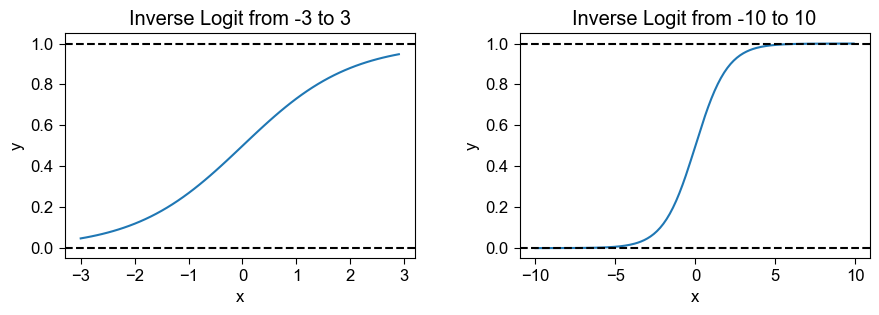

In [91]:
from scipy.special import expit
def gen_expit_plot(xmin, xmax):
    x_vals = np.arange(xmin, xmax, 0.1)
    y_vals = expit(x_vals)
    expit_df = pd.DataFrame({'x': x_vals, 'y': y_vals})
    ax = pw.Brick(figsize=(3.5, 2.25))
    sns.lineplot(
        x="x", y="y", data=expit_df, ax=ax
    );
    ax.axhline(y=0, ls='dashed', color='black');
    ax.axhline(y=1, ls='dashed', color='black');
    ax.set_title(f"Inverse Logit from {xmin} to {xmax}")
    return ax
ax_narrow = gen_expit_plot(-3, 3);
ax_wide = gen_expit_plot(-10, 10);
ax_combined = ax_narrow | ax_wide;
ax_combined.savefig()

We can see that, no matter how wide the range of values we "plug into" $\text{logit}^{-1}(\cdot)$ is, it will always compress these values to be between $0$ and $1$, and thus into a value which can be used as the $p$ parameter in our Bernoulli variable `sayhire`!

### The Interaction Term $\beta_{rc}r_ic_i$

On top of the details above about the utility of $\text{logit}^{-1}(\cdot)$ for our model, there's one more factor we'll need to consider for our model: what terms specifically to include as **features!** It's kind of... not obvious *a priori*, in a given modeling scenario, whether or not you should include or omit features representing **interactions** between individual features. In this case, however, there's a good reason to include this interaction term.

If you want to take it on faith that there's a good reason and get on with the homework, **you can <span style='background-color: rgba(255,220,116,0.5);'>skip the following mathy stuff and move on to Q1.5.1</span>**!

But, for my brain at least, I try to always take the time to write out this logic so I can explicitly justify including or not-including interaction terms.

### What the Interaction Term *Does* in a Linear Model

First, note that the function $\text{logit}^{-1}(x)$ can be written in two different ways, which are each helpful in different contexts:

$$
\begin{align*}
\text{logit}^{-1}(x) &\equiv \boxed{\frac{1}{1 + e^{-x}}} \\
&= \frac{1}{1 + e^{-x}} \cdot \left( \frac{e^x}{e^x} \right) = \frac{e^x}{(1 + e^{-x})e^x} = \frac{e^x}{e^x + e^{-x}e^x} = \frac{e^x}{e^x + e^0} \\
&= \boxed{\frac{e^x}{e^x + 1}}
\end{align*}
$$

So, we can now use either one to see how our model lets us straightforwardly **transform** any value we'd like from the $(-\infty, \infty)$ domain (so, the domain of unbounded continuous real numbers) and the $[0, 1]$ domain (the domain of probabilities). Letting $p_i \equiv \Pr(H_i = 1 \mid R_i = r_i, C_i = c_i)$, we obtain:

$$
\begin{align*}
&p_i = \text{logit}^{-1}(\alpha + \beta_r r_i + \beta_c c_i) \\
\iff &p_i = \frac{1}{1 + e^{-\alpha - \beta_r r_i - \beta_c c_i}} \\
\iff &p_i \left(1 + e^{-\alpha - \beta_r r_i - \beta_c c_i} \right) = 1 \\
\iff &p_i + p_ie^{-\alpha - \beta_r r_i - \beta_c c_i} = 1 \\
\iff &p_ie^{-\alpha - \beta_r r_i - \beta_c c_i} = 1 - p_i \\
\iff &e^{-\alpha - \beta_r r_i - \beta_c c_i} = \frac{1 - p_i}{p_i} \\
\iff &\log\left[ e^{-\alpha - \beta_r r_i - \beta_c c_i} \right] = \log \left[ \frac{1 - p_i}{p_i} \right] \\
\iff &-\alpha - \beta_r r_i - \beta_c c_i = \log(1 - p_i) - \log(p_i) \\
\iff &(-1)(-\alpha - \beta_r r_i - \beta_c c_i) = (-1)(\log(1 - p_i) - \log(p_i)) \\
\iff &\alpha + \beta_r r_i + \beta_c c_i = \log(p_i) - \log(1 - p_i) \\
\iff &\alpha + \beta_r r_i + \beta_c c_i = \log\left[ \frac{p_i}{1 - p_i} \right]
\end{align*}
$$

Now, let's consider what this model would look like with and without the interaction term $r_ic_i$:

### Model 1: No Interaction Term

$$
\log\left[
  \frac
    {\Pr(H_i = 1 \mid R_i = r_i, C_i = c_i)}
    {1 - \Pr(H_i = 1 \mid R_i = r_i, C_i = c_i)}
\right] = \alpha + \beta_c c_i + \beta_r r_i
$$

First, consider the vignettes where Chad does **not** have a prior criminal conviction. So, rows where $c_i = 0$. In this case, Model 1 becomes:

$$
\log\left[
  \frac
    {\Pr(H_i = 1 \mid R_i = r_i, C_i = 0)}
    {1 - \Pr(H_i = 1 \mid R_i = r_i, C_i = 0)}
\right] = \begin{cases}
\alpha &\text{if }r_i = 0, \\
\alpha + \beta_r &\text{if }r_i = 1
\end{cases}
$$

And this means that the estimated difference in the log-odds of `sayhire`, between the white and black vignettes, will just be $\beta_r$.

Next, consider the vignettes where Chad **does** have a prior criminal conviction. For these observations $i$ with $c_i = 1$, Model 1 instead becomes:

$$
\log\left[
  \frac{p_i}{1 - p_i}
\right] = \begin{cases}
\alpha + \beta_c &\text{if }r_i = 0, \\
\alpha + \beta_c + \beta_r &\text{if }r_i = 1
\end{cases}
$$

So, the estimated difference in the log-odds of `sayhire`, between the black and white vignettes, will again just be $\beta_r$ here.

The takeaway from all this is that **omitting the interaction term means we're *assuming* that the `race` variable has the same impact on the log-odds of `sayhire` for *former-conviction-Chad* and *no-former-conviction-Chad*... Now let's compare this with the version of the model which *includes* the interaction term:

### Model 2: Interaction Term Included

$$
\log\left[
  \frac{p_i}{1 - p_i}
\right] = \alpha + \beta_c c_i + \beta_r r_i + \beta_{cr}(c_i r_i),
$$

Consider again the vignettes where Chad does **not** have a prior criminal conviction. So, rows where $c_i = 0$. Model 2 then becomes:

$$
\log\left[
  \frac{p_i}{1 - p_i}
\right] = \begin{cases}
\alpha &\text{if }r_i = 0, \\
\alpha + \beta_r &\text{if }r_i = 1
\end{cases}
$$

So that, like in Model 1, the estimated difference in the log-odds of `sayhire` between the white and black vignettes is just $\beta_r$.

However, now consider the vignettes where Chad **does** have a prior criminal conviction. For these observations $i$ with $c_i = 1$, Model 2 becomes:

$$
\log\left[
  \frac{p_i}{1 - p_i}
\right] = \begin{cases}
\alpha + \beta_c &\text{if }r_i = 0, \\
\alpha + \beta_c + \beta_r + \beta_{cr} &\text{if }r_i = 1
\end{cases}
$$

So that now the estimated difference in the log-odds of `sayhire` between the black and white vignettes takes on a **different** value from that of Model 1: $\beta_r + \beta_{cr}$

The takeaway, if you've read this far, is that **Model 2 provides us with an additional free parameter** that we can use to estimate the **differential impact of `race` on applicants with and without prior convictions (and, symmetrically, the differential impact of `conviction` for white vs. black applicants)!**

### [Question 1.5.1] Write and Visualize the Logistic Regression Model

This is your time to shine! Use what you know about logistic regression (from, e.g., the above discussion) and PyMC to construct a **multivariate model of employer attitudes** named `mva_model` (`mva_model` as in, **m**ulti**v**ariate **a**ttitude model).

The main hint for this part is just that, given the above discussion on using $\text{logit}^{-1}(\cdot)$ to "translate" back and forth between $(-\infty,infty)$ and $[0,1]$, **you will likely find PyMC's `pm.math.invlogit()` function extremely helpful!**

Once you've written the model, uncomment the `pm.model_to_graphviz()` call provided at the end of the code cell to visualize the model as a PGM. If set up correctly (though there are multiple ways of writing this model!), it should look something like the following:

<center>
<img src="https://raw.githubusercontent.com/jpowerj/dsan-content/57a1df179d9e74464a80dc337e96851623d30a65/2025-sum-dsan5650/hw3/sayhire_multivar.svg" width="60%" />
</center>

In [ ]:
# @title Q1.5.1-response
coords = {'response_id': X_train.index.values}

# Your code here: Implement multivariate (logistic regression) model as described
# above

# Once you've written the model, uncomment the following line to generate a
# visual PGM representation of the model

# pm.model_to_graphviz(mva_model)

In [96]:
# @title Q1.5.1-public-tests
q1_5_1_public_tests = {
    'mva_model defined': '✅ Passed!' if 'mva_model' in globals() else "🔲 No variable named 'mva_model' exists in Python memory",
}
q1_5_1_public_tests

{'mva_model defined': '✅ Passed!'}

### [Question 1.5.2] Parameter RVs vs. Data RVs

As you did in earlier parts, specify which of the following Python variables represent **latent *parameters* that we'd like to estimate via `mva_model`**:

* (a) `con_obs`
* (b) `race_obs`
* (c) `beta_c`
* (d) `beta_rc`
* (e) `beta_r`
* (f) `alpha`
* (g) `p_sayhire`
* (h) `sayhire`
* (i) `sayhire_obs`

In [97]:
# @title Q1.5.2-response
q1_5_2_response = {
    'a': False,
    'b': False,
    'c': False,
    'd': False,
    'e': False,
    'f': False,
    'g': False,
    'h': False,
    'i': False,
}

In [98]:
# @title Q1.5.2-public-tests
q1_5_2_public_tests = {
    'q1_5_2_response defined': '✅ Passed!' if 'q1_5_2_response' in globals() else "🔲 No variable named 'q1_5_2_response' exists in Python memory",
}
q1_5_2_public_tests

{'q1_5_2_response defined': '✅ Passed!'}

### [Question 1.5.3] Estimate Model Parameters

As you did in earlier parts, here estimate the posterior distributions over possible values of the parameters in `mva_model`, storing the result in a variable named `mva_idata`. The provided code will condense these full distributions down into their **means**, which you'll then **interpret** in Question 1.5.4.

In [ ]:
# @title Q1.5.3-response

# Your code here: Estimate posterior distributions

# Once you've stored the posterior estimates in mva_idata, uncomment the following
# line to generate a summary table of the model parameter distributions

# az.summary(mva_idata)

In [101]:
# @title Q1.5.3-public-tests
q1_5_3_public_tests = {
    'mva_idata defined': '✅ Passed!' if 'mva_idata' in globals() else "🔲 No variable named 'mva_idata' exists in Python memory",
}
q1_5_3_public_tests

{'mva_idata defined': '✅ Passed!'}

### [Question 1.5.4] Interpret Parameter Distributions

Since we now have a multivariable model, there are **four** different **point estimates** that we can derive solely from our estimates of `alpha`, `beta_r`, `beta_c`, and `beta_rc`:

* $\Pr(\texttt{dohire}_i \mid \texttt{race}_i = \text{White}, \texttt{con}_i = 0)$
* $\Pr(\texttt{dohire}_i \mid \texttt{race}_i = \text{Black}, \texttt{con}_i = 0)$
* $\Pr(\texttt{dohire}_i \mid \texttt{race}_i = \text{White}, \texttt{con}_i = 1)$
* $\Pr(\texttt{dohire}_i \mid \texttt{race}_i = \text{Black}, \texttt{con}_i = 1)$

In [107]:
# @title Q1.5.4-response
# Your code here: compute conditional probability estimates,
# using the mvm_estimates Series object you created above

# Once they're computed, replace None values at the end of the code cell with
# the estimated probability values
from enum import Enum
from dataclasses import dataclass

class Race:
    White = 0
    Black = 1

@dataclass(frozen=True)
class TesterProfile:
    race: Race
    conviction: bool

# (Replace None values to complete the dictionary object)
q1_5_4_response = {
    TesterProfile(race="White", conviction=0): None,
    TesterProfile(race="White", conviction=1): None,
    TesterProfile(race="Black", conviction=0): None,
    TesterProfile(race="Black", conviction=1): None,
}

In [108]:
# @title Q1.5.4-public-tests
def all_none(response_dict):
    response_vals = list(response_dict.values())
    return all([v is None for v in response_vals])
q1_5_4_public_tests = {
    'q1_5_4_response defined': '✅ Passed!' if 'q1_5_4_response' in globals() else "🔲 No variable named 'q1_5_4_response' exists in Python memory",
    'No None values': '✅ Passed!' if ('q1_5_4_response' in globals()) and (not all_none(q1_5_4_response)) else "🔲 One or more of the values in 'q1_5_4_response' is None",
}
q1_5_4_public_tests

{'q1_5_4_response defined': '✅ Passed!',
 'No None values': "🔲 One or more of the values in 'q1_5_4_response' is None"}

### [Question 1.5.5] Evaluate Predictive Performance on Training Data

In [ ]:
# @title Q1.5.5-response

# Your code here: draw from posterior predictive distribution of mva_model

az.summary(mva_train_idata)
mva_train_means = mva_train_idata.posterior_predictive['hired'].mean(dim=['chain','draw'])
plot_roc(y_train, mva_train_meanhired, "Train ROC: Multivar Model")

In [109]:
# @title Q1.5.5-public-tests
q1_5_5_public_tests = {
    'mva_train_idata defined': '✅ Passed!' if 'mva_train_idata' in globals() else "🔲 No variable named 'mva_train_idata' exists in Python memory",
}
q1_5_5_public_tests

{'mva_train_idata defined': "🔲 No variable named 'mva_train_idata' exists in Python memory"}

### [Question 1.5.6] Evaluate Predictive Performance on Test Data

In [ ]:
# @title Q1.5.6-response
mva_test_coords = {
    'i': X_test.index.values
}

# Your code here: Update data in mva_model to be test data, then re-estimate
# posterior predictive distributions

# Provided code step 1: Compute posterior predictive means
mva_test_meanhired = mva_test_idata.posterior_predictive['hired'].mean(dim=['chain','draw'])
# Provided code step 2: Plot test ROC curve
mva_auc = plot_roc(y_test, mva_test_meanhired, "Test ROC: Multivar Model")
# Provided code step 3: Store resulting AUC score
survey_model_aucs['multivar'] = mva_auc
survey_model_aucs

In [125]:
# @title Q1.5.6-public-tests
q1_5_6_public_tests = {
    'mva_test_idata defined': '✅ Passed!' if 'mva_test_idata' in globals() else "🔲 No variable named 'mva_test_idata' exists in Python memory",
}
q1_5_6_public_tests

{'mva_test_idata defined': "🔲 No variable named 'mva_test_idata' exists in Python memory"}

### [Question 1.5.7] Check (Approximate) Agreement with `scikit-learn`

In [6]:
# @title Q1.5.7-response
from sklearn.linear_model import LogisticRegression

# Your code here: estimate the same parameters, using the same data, but with
# scikit-learn's LogisticRegression() class rather than PyMC

In [7]:
# @title Q1.5.7-public-tests
q1_5_7_public_tests = {
    'lr_model defined': '✅ Passed!' if 'lr_model' in globals() else "🔲 No variable named 'lr_model' exists in Python memory",
    'lr_coefs defined': '✅ Passed!' if 'lr_coefs' in globals() else "🔲 No variable named 'lr_coefs' exists in Python memory",
    'lr_predictions defined': '✅ Passed!' if 'lr_predictions' in globals() else "🔲 No variable named 'lr_predictions' exists in Python memory",
}
q1_5_7_public_tests

{'lr_model defined': "🔲 No variable named 'lr_model' exists in Python memory",
 'lr_coefs defined': "🔲 No variable named 'lr_coefs' exists in Python memory",
 'lr_predictions defined': "🔲 No variable named 'lr_predictions' exists in Python memory"}

## [Part 1.6] Comparing Models

You made it! The last thing to do is just to **plot the AUC scores** for each of the models we've estimated, to see which one comes out on top in terms of predictive accuracy for **unseen** survey responses!

If you've implemented and estimated everything correctly in Parts 1.1 through 1.5, you should be able to run the following cell to generate this comparative plot (and receive free points!)

### [Question 1.6.1] Generate Model-Comparison Plot

In [ ]:
# @title Q1.6.1-response
# (No need to change anything here; free points!)
auc_df = pd.DataFrame(survey_model_aucs.items(), columns=['model','auc'])
ax = pw.Brick(figsize=(5, 3.5));
sns.barplot(
    x='model', y='auc', data=auc_df, ax=ax
);
ax.set_title("Out-of-Sample Predictive Performance, Employer Attitude Models")
ax.savefig()

In [ ]:
# @title Q1.6.1-public-tests
q1_6_1_public_tests = {
    'auc_df defined': '✅ Passed!' if 'auc_df' in globals() else "🔲 No variable named 'auc_df' exists in Python memory",
}
q1_6_1_public_tests

### [Question 1.6.2] Best-Performing Model

Which model performed best? **(Choose one option, by replacing the blank string in the response cell with the letter of the option)**

* (a) The baseline model (`nofeats`)
* (b) The conviction-only model (`conviction_only`)
* (c) The race-only model (`race_only`)
* (d) The multivariate logistic regression movel (`multivar`)

In [121]:
# @title Q1.6.2-response
q1_6_2_response = "" # Replace with the letter for the option you'd like to choose, e.g., "a" for option (a)

In [122]:
# @title Q1.6.2-public-tests
q1_6_2_public_tests = {
    'q1_6_2_response defined': '✅ Passed!' if 'q1_6_2_response' in globals() else "🔲 No variable named 'q1_6_2_response' exists in Python memory",
}
q1_6_2_public_tests

{'q1_6_2_response defined': '✅ Passed!'}

### [Question 1.6.3] Expected Best-Performing Model

Is it the model you were expecting? **(Choose one option as in Q1.6.2... No incorrect answers! Free points!)**

* (a) Yes
* (b) No

In [123]:
# @title Q1.6.3-response
q1_6_3_response = "" # Replace with the letter for the option you'd like to choose, e.g., "a" for option (a)

In [124]:
# @title Q1.6.3-public-tests
q1_6_3_public_tests = {
    'q1_6_3_response defined': '✅ Passed!' if 'q1_6_3_response' in globals() else "🔲 No variable named 'q1_6_3_response exists in Python memory",
}
q1_6_3_public_tests

{'q1_6_3_response defined': '✅ Passed!'}

*(...I suppose Q1.6.3 was a somewhat leading question. But the takeaway is **not** that Bayesian Logistic Regression itself is trash! Rather, it's that we need to learn about **regularizing priors**, which we should get to by Week 12!)*

Onto **Part 2!**

# [Part 2] Modeling *Behaviors* with Experimental Audit Data

In this part, we'll start to see the issue with conflating attitudes and behavior (so, in other words, the dangers that can arise from assuming that **survey responses** can be used as a "mirror" for real-world **behavior**), which will motivate the move in Part 3 below to *merge* the survey and experimental-audit data and analyze this discrepancy itself.

But, don't worry! This part won't involve another 7 tedious steps of doing the same thing you did in Part 1! Instead, we'll use it as an opportunity to explore a package called [**Bambi**](https://bambinos.github.io/bambi/), which is essentially a wrapper around more in-the-weeds Bayesian model-building tools like PyMC.

> *The **social contract** here, though, is that you promise to **keep your Bayesian modeling skills sharp**, the skills you've built in HW2 and in Part 1 above!*
>
> *I say that here because, using Bambi essentially takes us *away from* the PyMC modeling approach---the **"learning a modeling *language*"** approach---and back towards just choosing from a collection of pre-made, "off-the-shelf" algorithms: the approach of using `lm()` or `statsmodels` for example.*

So yeah, in general I want you to avoid seeing `lm()` or `statsmodels` as "default" approaches, and instead see them as tools you can take advantage of **after** you've gone through the modeling steps and determined that the assumptions underlying e.g. logistic regression are appropriate for your scenario. *But*, since you just trooped through the non-off-the-shelf "hard mode" approach in Part 1, and "arrived at" the use of logistic regression in Part 1.6, in this part we'll basically just skip those hard parts and ask Bambi to run a Bayesian logistic regression for us (with PyMC still running "under the hood"!)